# 03: Survival Analysis

This notebook implements **proper survival analysis** using time-to-event modelling, as opposed to the binary classification approach in notebook 02.

**Why survival analysis?**
- Binary classification treats a patient who dies at 3 months identically to one who dies at 4 years
- Survival analysis uses the actual time-to-event information
- Properly handles **censored** observations (patients still alive at last follow-up)
- Reports **C-index** (concordance index) rather than AUC

**Models implemented:**
1. Cox Proportional Hazards (baseline linear model)
2. Random Survival Forest (ensemble method)
3. Gradient Boosted Survival (tree-based boosting)

**Expected outcome:**
C-index in the range 0.65-0.72, comparable to binary classification AUC but using more information from the data.

## Setup

### Install Dependencies

In [224]:
!pip install scikit-survival -q

### Core Imports

In [225]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
import warnings

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

### Survival Analysis Imports

In [226]:
from sksurv.ensemble import RandomSurvivalForest, GradientBoostingSurvivalAnalysis
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.metrics import concordance_index_censored
from sksurv.nonparametric import kaplan_meier_estimator

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.base import clone

### Mount Drive & Set Paths

In [227]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

from google.colab import userdata
GLIOMA_DIR = userdata.get("GLIOMA_DIR")
print(f"Glioma directory: {os.path.join(GLIOMA_DIR)}")

Mounted at /content/drive/
Glioma directory: drive/MyDrive/Y3 Project/Data/PKG_MU_Glioma_Post


In [228]:
figures_dir = os.path.join(GLIOMA_DIR, 'results', 'figures')
os.makedirs(figures_dir, exist_ok=True)
print(f"Figures directory: {figures_dir}")

Figures directory: drive/MyDrive/Y3 Project/Data/PKG_MU_Glioma_Post/results/figures


## Load Data

### Load Preprocessed Features

In [229]:
preprocessed_dir = os.path.join(GLIOMA_DIR, 'preprocessed')

X = pd.read_pickle(os.path.join(preprocessed_dir, 'X.pkl'))
y = pd.read_pickle(os.path.join(preprocessed_dir, 'y.pkl'))
high_fill_df = pd.read_pickle(os.path.join(preprocessed_dir, 'high_fill_df.pkl'))

print(f"Loaded X: {X.shape}")
print(f"Loaded y: {y.shape}")
print(f"Loaded high_fill_df: {high_fill_df.shape}")

Loaded X: (203, 28)
Loaded y: (203,)
Loaded high_fill_df: (203, 29)


### Load Original Data for Survival Time

The preprocessed `high_fill_df` does not contain the survival time column because:
- `Number of days from Diagnosis to death (Days)` was dropped during preprocessing (47% fill rate)
- This column only has values for patients who died; censored patients have NaN

We need to:
1. Retrieve survival time for patients who died from original data
2. Estimate follow-up time for censored patients using their last MRI date

In [230]:
# Load original Excel file
original_data_path = os.path.join(GLIOMA_DIR, 'MU_Glioma_Post_ClinicalData_July2025.xlsx')
df_original = pd.read_excel(original_data_path, sheet_name=1)

# Standardise column names to lowercase
df_original.columns = df_original.columns.str.lower().str.strip()

print(f"Original data shape: {df_original.shape}")
print(f"\nColumns containing 'days' or 'death':")
for col in df_original.columns:
    if 'days' in col or 'death' in col:
        print(f"  - {col}")

Original data shape: (203, 74)

Columns containing 'days' or 'death':
  - time to first progression (days)
  - overall survival (death)
  - number of days from diagnosis to death (days)
  - number of days from diagnosis to first surgery or procedure
  - number of days from diagnosis to initial chemo therapy start date
  - number of days from diagnosis to initial chemo therapy end date
  - number of days from diagnosis to radiation therapy start date
  - number of days from diagnosis to radiation therapy end date
  - number of days from diagnosis to date of first progression
  - number of days from diagnosis to date of further progression
  - days from diagnosis to new treatment
  - cycle length of additional therapy (q days)
  - number of days from diagnosis to starting additional therapy
  - number of days from diagnosis to complete additional therapy
  - cycle length of 2nd_additional therapy (q days)
  - number of days from diagnosis to starting 2nd_additional therapy
  - number of 

### Construct Survival Time Variable

For survival analysis we need:
- **Event indicator**: Did the patient die? (0=censored/alive, 1=died)
- **Time to event**: Days from diagnosis to death (if died) OR last follow-up (if censored)

For censored patients, we use the **latest MRI timepoint** as a proxy for last known follow-up.

In [231]:
# Extract death indicator and days-to-death
death_col = 'overall survival (death)'
days_to_death_col = 'number of days from diagnosis to death (days)'

# MRI timepoint columns for estimating follow-up time
mri_cols = [
    'number of days from diagnosis to 1st mri (timepoint_1)',
    'number of days from diagnosis to 2nd mri (timepoint_2)',
    'number of days from diagnosis to 3rd mri (timepoint_3)',
    'number of days from diagnosis to 4th mri (timepoint_4)',
    'number of days from diagnosis to 5th mri (timepoint_5)',
    'number of days from diagnosis to 6th mri (timepoint_6)'
]

# Filter to only MRI columns that exist
mri_cols = [col for col in mri_cols if col in df_original.columns]
print(f"Available MRI timepoint columns: {len(mri_cols)}")

Available MRI timepoint columns: 6


In [232]:
# Get event indicator
event = df_original[death_col].values.astype(bool)

"""
Get survival time
For patients who died: use days-to-death
For censored patients: use maximum MRI timepoint as proxy for last follow-up
"""

survival_time = np.zeros(len(df_original))

for i in range(len(df_original)):
    if event[i]:  # Patient died
        survival_time[i] = df_original.loc[i, days_to_death_col]
    else:  # Censored (alive)
        # Take max of available MRI timepoints as a proxy for survival time
        mri_times = df_original.loc[i, mri_cols].values
        valid_times = mri_times[~pd.isna(mri_times)]
        if len(valid_times) > 0:
            survival_time[i] = np.max(valid_times)
        else:
            # Default follow-up to NaN (handled later)
            survival_time[i] = np.nan

print(f"Survival times computed: {len(survival_time)}")
print(f"Missing survival times: {np.isnan(survival_time).sum()}")
print(survival_time)

Survival times computed: 203
Missing survival times: 2
[ 286.   67.  367.  365.  968.  482.   97.  369.  185.  244.  396.  611.
   42.  482.  379.  401.  456.  156.  243.  215.  375.  145.   44.  913.
  553.  513.  398.  618.  357.  422.  495.  371.  482.  473.   16.  182.
   64.   63.   34.  249.   25.  103.   76.  300.  225.  651.  263.  648.
  594.    9. 1326. 1332.   76.   62.   76.  148.  160.  204.  579.  203.
  189.  470.  420.    0. 1005.  463.   84.   89.    0.  645.  281.  213.
   24.  207.  591.  656.  335.    0.  311.   36.  977.  690.   48.   88.
  265.  736.  551.  400.   41.    0.  554.  499.  124.   37.  242.  551.
   11.  302.  424.   86.    3.   nan  402.  280.    5.  736.  399.  236.
  137.    3.    4.  424.  -11.  565.   90.  479.   16.  674.   10.  128.
   31.    6.  192.  189.   20.  316.  543.   63.  248.    8.  220.  334.
  227.  382.  231.  254.  404.  202.    5.    7.  172.  178.  153.   46.
   97.  508.  301.   45. 1219.  635.  981.  303.  436.  147.  237.  1

### Handle Missing Survival Times

In [233]:
missing_mask = np.isnan(survival_time)

if missing_mask.sum() > 0:
    print(f"Patients with missing survival time: {missing_mask.sum()}")
    print(f"  - Died: {event[missing_mask].sum()}")
    print(f"  - Censored: {(~event[missing_mask]).sum()}")

    # Calculate group-specific medians for imputation
    censored_valid = (~event) & (~missing_mask)
    died_valid = event & (~missing_mask)

    median_censored = np.median(survival_time[censored_valid]) if censored_valid.sum() > 0 else 30
    median_died = np.median(survival_time[died_valid]) if died_valid.sum() > 0 else 30

    # Impute censored patients
    censored_missing = (~event) & missing_mask
    if censored_missing.sum() > 0:
        survival_time[censored_missing] = median_censored
        print(f"\nImputed {censored_missing.sum()} censored patients with median follow-up: {median_censored:.0f} days")

    # Impute died patients
    died_missing = event & missing_mask
    if died_missing.sum() > 0:
        survival_time[died_missing] = median_died
        print(f"Imputed {died_missing.sum()} died patients with median death time: {median_died:.0f} days")
else:
    print("No missing survival times.")

Patients with missing survival time: 2
  - Died: 1
  - Censored: 1

Imputed 1 censored patients with median follow-up: 215 days
Imputed 1 died patients with median death time: 336 days


### Validate Survival Data

In [234]:
# Basic validation
print("Survival Data Summary")
print("-"*30)
print(f"Total patients: {len(survival_time)}")
print(f"Events (deaths): {event.sum()} ({event.mean()*100:.1f}%)")
print(f"Censored (alive): {(~event).sum()} ({(~event).mean()*100:.1f}%)")
print(f"\nSurvival time (days):")
print(f"  Min: {survival_time.min():.0f}")
print(f"  Max: {survival_time.max():.0f}")
print(f"  Median: {np.median(survival_time):.0f}")
print(f"  Mean: {survival_time.mean():.0f}")

# Check for negative times (can happen with date discrepancies as diagnosis can come after operation)
negative_times = survival_time < 0
if negative_times.sum() > 0:
    print(f"WARNING: {negative_times.sum()} patients have negative survival time")
    # These patients have no post-diagnosis follow-up recorded
    # Use median follow-up of other censored patients as proxy
    censored_positive = (~event) & (survival_time > 0)
    median_followup = np.median(survival_time[censored_positive])
    survival_time[negative_times] = median_followup
    print(f"Imputed with median censored follow-up: {median_followup:.0f} days")

Survival Data Summary
------------------------------
Total patients: 203
Events (deaths): 97 (47.8%)
Censored (alive): 106 (52.2%)

Survival time (days):
  Min: -17
  Max: 1332
  Median: 249
  Mean: 304
Imputed with median censored follow-up: 226 days


### Create Structured Survival Target

In [235]:
# scikit-survival requires a structured array with dtype [('event', bool), ('time', float)]
y_surv = np.array(
    [(evt, t) for evt, t in zip(event, survival_time)],
    dtype=[('event', bool), ('time', float)]
)

print(f"Structured survival target created: {len(y_surv)} samples")
print(f"dtype: {y_surv.dtype}")

Structured survival target created: 203 samples
dtype: [('event', '?'), ('time', '<f8')]


### Visualise Survival Time Distribution

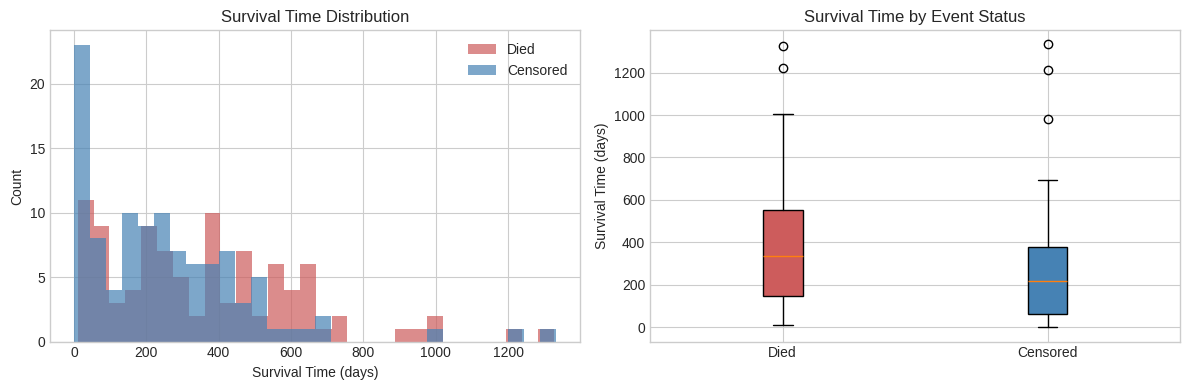

In [236]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Histogram by event status
axes[0].hist(survival_time[event], bins=30, alpha=0.7, label='Died', color='indianred')
axes[0].hist(survival_time[~event], bins=30, alpha=0.7, label='Censored', color='steelblue')
axes[0].set_xlabel('Survival Time (days)')
axes[0].set_ylabel('Count')
axes[0].set_title('Survival Time Distribution')
axes[0].legend()

# Box plot by event status
bp = axes[1].boxplot([survival_time[event], survival_time[~event]],
                      labels=['Died', 'Censored'], patch_artist=True)
bp['boxes'][0].set_facecolor('indianred')
bp['boxes'][1].set_facecolor('steelblue')
axes[1].set_ylabel('Survival Time (days)')
axes[1].set_title('Survival Time by Event Status')

plt.tight_layout()
plt.savefig(os.path.join(figures_dir, '03_survival_time_distribution.png'), dpi=300, bbox_inches='tight')
plt.show()

## Prepare Features

### Remove Leakage Features

Same features removed in notebook 02 must be removed here.

In [237]:
leakage_features = [
    'second progression/recurrence',
    'type of 2nd progression',
    'time to first progression (days)',
    'number of days from diagnosis to date of first progression',
    'number of days from diagnosis to first surgery or procedure',
    'progression',
    'type of 1st progression'
]

features_to_remove = [f for f in leakage_features if f in X.columns]
X_clean = X.drop(columns=features_to_remove, errors='ignore')

print(f"Original features: {X.shape[1]}")
print(f"Features removed: {len(features_to_remove)}")
print(f"Clean features: {X_clean.shape[1]}")

Original features: 28
Features removed: 7
Clean features: 21


### Identify Feature Types

In [238]:
categorical_cols = X_clean.select_dtypes(include=['object', 'category']).columns.tolist()
numeric_cols = X_clean.select_dtypes(include=[np.number]).columns.tolist()

print(f"Categorical features ({len(categorical_cols)}):")
for col in categorical_cols:
    print(f"  - {col}")

print(f"\nNumeric features ({len(numeric_cols)}):")
for col in numeric_cols:
    print(f"  - {col}")

Categorical features (4):
  - sex at birth
  - race
  - primary diagnosis
  - previous brain tumor

Numeric features (17):
  - age at diagnosis
  - grade of primary brain tumor
  - stereotactic biopsy before surgical resection
  - idh1 mutation
  - idh2 mutation
  - 1p/19q
  - atrx mutation
  - mgmt methylation
  - braf v600e mutation
  - tert promoter mutation
  - chromosome 7 gain and chromosome 10 loss
  - h3-3a mutation
  - egfr amplification
  - pten mutation
  - cdkn2a/b deletion
  - tp53 alteration
  - number of days from diagnosis to 1st mri (timepoint_1)


### Encode Categorical Features

In [239]:
X_encoded = pd.get_dummies(X_clean, columns=categorical_cols, drop_first=True)
print(f"Features after one-hot encoding: {X_encoded.shape[1]}")

Features after one-hot encoding: 27


### Handle Missing Values

In [240]:
missing_counts = X_encoded.isnull().sum()
cols_with_missing = missing_counts[missing_counts > 0]

if len(cols_with_missing) > 0:
    print(f"Columns with missing values ({len(cols_with_missing)}): {cols_with_missing}\n")

    imputer = SimpleImputer(strategy='median')
    X_encoded = pd.DataFrame(
        imputer.fit_transform(X_encoded),
        columns=X_encoded.columns,
        index=X_encoded.index
    )
    print(f"\nMissing values imputed with median.")
else:
    print("No missing values.")

Columns with missing values (1): number of days from diagnosis to 1st mri (timepoint_1)    16
dtype: int64


Missing values imputed with median.


### Remove Zero-Variance Features

In [241]:
variances = X_encoded.var()
zero_var_cols = variances[variances == 0].index.tolist()

if zero_var_cols:
    print(f"Removing {len(zero_var_cols)} zero-variance features:")
    for col in zero_var_cols:
        print(f"  - {col}")
    X_encoded = X_encoded.drop(columns=zero_var_cols)
else:
    print("No zero-variance features.")

print(f"\nFinal feature matrix: {X_encoded.shape}")

No zero-variance features.

Final feature matrix: (203, 27)


## Evaluation Framework

### Concordance Index

The C-index measures how well the model ranks patients by risk. If we pick two patients at random where one died before the other, did the model correctly rank the one who died first as higher risk?

- C-index = 0.5 is random guessing
- C-index = 1.0 is perfect ranking

In [242]:
def calculate_cindex(model, X, y_surv):
    """Calculate concordance index for a fitted survival model."""
    risk_scores = model.predict(X)
    c_index = concordance_index_censored(
        y_surv['event'],
        y_surv['time'],
        risk_scores
    )[0]
    return c_index

### Cross-Validation Function

In [243]:
def cross_validate_survival(model, X, y_surv, n_splits=5, random_state=42):
    """
    Perform stratified k-fold cross-validation for survival models.
    Stratification is by event status to ensure balanced folds.
    """
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    event_labels = y_surv['event'].astype(int)

    c_indices = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X, event_labels)):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y_surv[train_idx], y_surv[val_idx]

        model_clone = clone(model)
        model_clone.fit(X_train, y_train)

        c_index = calculate_cindex(model_clone, X_val, y_val)
        c_indices.append(c_index)

        print(f"  Fold {fold+1}: C-index = {c_index:.4f}")

    return {
        'c_index_mean': np.mean(c_indices),
        'c_index_std': np.std(c_indices),
        'c_index_scores': c_indices
    }

## Model 1: Cox Proportional Hazards

The Cox PH model is the standard baseline for survival analysis. It assumes the hazard ratio between any two patients is constant over time (proportional hazards assumption).

### Scale Features for Cox PH

In [244]:
scaler = StandardScaler()
X_scaled = pd.DataFrame(
    scaler.fit_transform(X_encoded),
    columns=X_encoded.columns,
    index=X_encoded.index
)
print(f"Features scaled: {X_scaled.shape}")

Features scaled: (203, 27)


### Train Cox PH

In [245]:
print("Training Cox Proportional Hazards model...")
print("-"*42)

cox_model = CoxPHSurvivalAnalysis(alpha=0.1)
cox_results = cross_validate_survival(cox_model, X_scaled, y_surv, n_splits=5)

print("-"*42)
print(f"Cox PH C-index: {cox_results['c_index_mean']:.4f} ± {cox_results['c_index_std']:.4f}")

Training Cox Proportional Hazards model...
------------------------------------------
  Fold 1: C-index = 0.6081
  Fold 2: C-index = 0.7264
  Fold 3: C-index = 0.7774
  Fold 4: C-index = 0.7259
  Fold 5: C-index = 0.4964
------------------------------------------
Cox PH C-index: 0.6669 ± 0.1018


### Cox PH Coefficients

In [246]:
cox_full = CoxPHSurvivalAnalysis(alpha=0.1)
cox_full.fit(X_scaled, y_surv)

cox_coefs = pd.DataFrame({
    'feature': X_scaled.columns,
    'coefficient': cox_full.coef_
})
cox_coefs['abs_coefficient'] = np.abs(cox_coefs['coefficient'])
cox_coefs = cox_coefs.sort_values('abs_coefficient', ascending=False)

print("Top 10 Cox PH coefficients (by absolute value):")
print(cox_coefs.head(10).to_string(index=False))

Top 10 Cox PH coefficients (by absolute value):
                                      feature  coefficient  abs_coefficient
             primary diagnosis_Diffuse glioma    -1.263765         1.263765
                 grade of primary brain tumor     0.882557         0.882557
                        primary diagnosis_GBM    -0.811122         0.811122
                             age at diagnosis     0.672761         0.672761
         primary diagnosis_Oligodendro-glioma    -0.662418         0.662418
                                   race_White     0.475550         0.475550
                                idh2 mutation    -0.426992         0.426992
stereotactic biopsy before surgical resection     0.417429         0.417429
               race_Black or African American     0.404896         0.404896
                                idh1 mutation     0.377883         0.377883


### Visualise Cox PH Coefficients

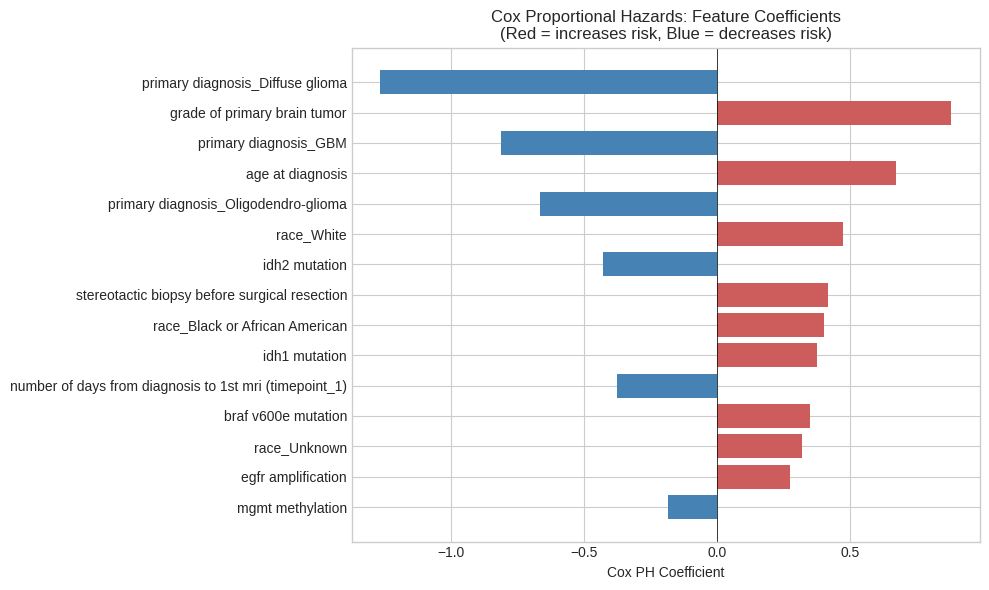

In [247]:
top_n = 15
top_coefs = cox_coefs.head(top_n).copy()

fig, ax = plt.subplots(figsize=(10, 6))

colors = ['indianred' if c > 0 else 'steelblue' for c in top_coefs['coefficient']]
ax.barh(range(len(top_coefs)), top_coefs['coefficient'], color=colors)

ax.set_yticks(range(len(top_coefs)))
ax.set_yticklabels(top_coefs['feature'])
ax.invert_yaxis()
ax.set_xlabel('Cox PH Coefficient')
ax.set_title('Cox Proportional Hazards: Feature Coefficients\n(Red = increases risk, Blue = decreases risk)')
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)

plt.tight_layout()
plt.savefig(os.path.join(figures_dir, '03_cox_coefficients.png'), dpi=300, bbox_inches='tight')
plt.show()

## Model 2: Random Survival Forest

Random Survival Forest extends random forests to survival data. Unlike Cox PH, it makes no proportional hazards assumption and can capture non-linear relationships.

### Train RSF

In [248]:
print("Training Random Survival Forest...")
print("-"*34)

rsf_model = RandomSurvivalForest(
    n_estimators=100,
    max_depth=4,
    min_samples_split=10,
    min_samples_leaf=5,
    n_jobs=-1,
    random_state=42
)

rsf_results = cross_validate_survival(rsf_model, X_encoded, y_surv, n_splits=5)

print("-"*34)
print(f"RSF C-index: {rsf_results['c_index_mean']:.4f} ± {rsf_results['c_index_std']:.4f}")

Training Random Survival Forest...
----------------------------------
  Fold 1: C-index = 0.7459
  Fold 2: C-index = 0.6195
  Fold 3: C-index = 0.7935
  Fold 4: C-index = 0.7434
  Fold 5: C-index = 0.6295
----------------------------------
RSF C-index: 0.7064 ± 0.0693


### RSF Feature Importance

In [249]:
from sklearn.inspection import permutation_importance

rsf_full = RandomSurvivalForest(
    n_estimators=100,
    max_depth=4,
    min_samples_split=10,
    min_samples_leaf=5,
    n_jobs=-1,
    random_state=42
)
rsf_full.fit(X_encoded, y_surv)

# Define a scorer function for permutation_importance using the C-index
def cindex_scorer(estimator, X, y):
    risk_scores = estimator.predict(X)
    c_index = concordance_index_censored(
        y['event'],
        y['time'],
        risk_scores
    )[0]
    return c_index

# Calculate permutation importance
result = permutation_importance(
    rsf_full,
    X_encoded,
    y_surv,
    scoring=cindex_scorer,
    n_repeats=10, # Number of times to permute a feature
    random_state=42,
    n_jobs=-1
)

rsf_importance = pd.DataFrame({
    'feature': X_encoded.columns,
    'importance': result.importances_mean
}).sort_values('importance', ascending=False)

print("Top 10 RSF feature importances (Permutation Importance):")
print(rsf_importance.head(10).to_string(index=False))

Top 10 RSF feature importances (Permutation Importance):
                                               feature  importance
                                      age at diagnosis    0.092719
number of days from diagnosis to 1st mri (timepoint_1)    0.068289
                                                1p/19q    0.004878
                                    egfr amplification    0.004460
                                      mgmt methylation    0.004222
                          grade of primary brain tumor    0.004198
                                       tp53 alteration    0.003047
                                     sex at birth_Male    0.002546
                                tert promoter mutation    0.002540
                                        h3-3a mutation    0.002343


### Visualise RSF Feature Importance

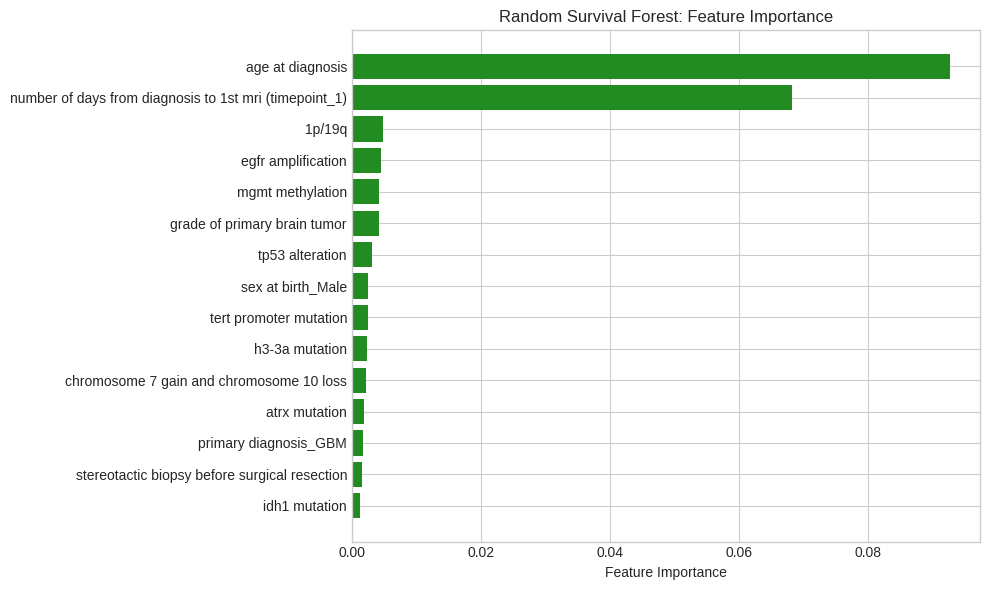

In [250]:
top_n = 15
top_importance = rsf_importance.head(top_n)

fig, ax = plt.subplots(figsize=(10, 6))

ax.barh(range(len(top_importance)), top_importance['importance'], color='forestgreen')
ax.set_yticks(range(len(top_importance)))
ax.set_yticklabels(top_importance['feature'])
ax.invert_yaxis()
ax.set_xlabel('Feature Importance')
ax.set_title('Random Survival Forest: Feature Importance')

plt.tight_layout()
plt.savefig(os.path.join(figures_dir, '03_rsf_feature_importance.png'), dpi=300, bbox_inches='tight')
plt.show()

## Model 3: Gradient Boosted Survival Analysis

Gradient boosting applied to survival analysis. Similar to XGBoost but designed for time-to-event data.

### Train GBSA

In [251]:
print("Training Gradient Boosted Survival Analysis...")
print("-"*46)

gbsa_model = GradientBoostingSurvivalAnalysis(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=3,
    min_samples_split=10,
    min_samples_leaf=5,
    subsample=0.8,
    random_state=42
)

gbsa_results = cross_validate_survival(gbsa_model, X_encoded, y_surv, n_splits=5)

print("-"*46)
print(f"GBSA C-index: {gbsa_results['c_index_mean']:.4f} ± {gbsa_results['c_index_std']:.4f}")

Training Gradient Boosted Survival Analysis...
----------------------------------------------
  Fold 1: C-index = 0.7378
  Fold 2: C-index = 0.5912
  Fold 3: C-index = 0.8032
  Fold 4: C-index = 0.7843
  Fold 5: C-index = 0.6079
----------------------------------------------
GBSA C-index: 0.7049 ± 0.0888


### GBSA Feature Importance

In [252]:
gbsa_full = GradientBoostingSurvivalAnalysis(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=3,
    min_samples_split=10,
    min_samples_leaf=5,
    subsample=0.8,
    random_state=42
)
gbsa_full.fit(X_encoded, y_surv)

gbsa_importance = pd.DataFrame({
    'feature': X_encoded.columns,
    'importance': gbsa_full.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 10 GBSA feature importances:")
print(gbsa_importance.head(10).to_string(index=False))

Top 10 GBSA feature importances:
                                               feature  importance
                                      age at diagnosis    0.394729
number of days from diagnosis to 1st mri (timepoint_1)    0.364777
                              previous brain tumor_Yes    0.039723
                          grade of primary brain tumor    0.039583
                                      mgmt methylation    0.027774
              chromosome 7 gain and chromosome 10 loss    0.022955
                                                1p/19q    0.019768
                                 primary diagnosis_GBM    0.019768
                                         idh1 mutation    0.013048
                                    egfr amplification    0.011619


## Model Comparison

### Compare All Survival Models

In [253]:
comparison = pd.DataFrame({
    'Model': ['Cox PH', 'Random Survival Forest', 'Gradient Boosted Survival'],
    'C-index Mean': [
        cox_results['c_index_mean'],
        rsf_results['c_index_mean'],
        gbsa_results['c_index_mean']
    ],
    'C-index Std': [
        cox_results['c_index_std'],
        rsf_results['c_index_std'],
        gbsa_results['c_index_std']
    ]
})

comparison['C-index'] = comparison.apply(
    lambda row: f"{row['C-index Mean']:.3f} ± {row['C-index Std']:.3f}",
    axis=1
)

print("\nSurvival Model Comparison")
print("-"*39)
print(comparison[['Model', 'C-index']].to_string(index=False))
print("-"*39)


Survival Model Comparison
---------------------------------------
                    Model       C-index
                   Cox PH 0.667 ± 0.102
   Random Survival Forest 0.706 ± 0.069
Gradient Boosted Survival 0.705 ± 0.089
---------------------------------------


### Compare with Binary Classification Results

In [254]:
results_dir = os.path.join(GLIOMA_DIR, 'results')
binary_results_path = os.path.join(results_dir, 'model_comparison.json')

if os.path.exists(binary_results_path):
    with open(binary_results_path, 'r') as f:
        binary_results = json.load(f)

    print("\nComparison: Binary Classification vs Survival Analysis")
    print("-"*67)
    print(f"{'Approach':<35} {'Metric':<12} {'Value':<20}")
    print("-"*67)

    if 'clean' in binary_results:
        clean_auc = binary_results['clean']['auc_mean']
        clean_std = binary_results['clean']['auc_std']
        print(f"{'Binary Classification (Clean XGB)':<35} {'AUC':<12} {clean_auc:.3f} ± {clean_std:.3f}")

    print(f"{'Cox Proportional Hazards':<35} {'C-index':<12} {cox_results['c_index_mean']:.3f} ± {cox_results['c_index_std']:.3f}")
    print(f"{'Random Survival Forest':<35} {'C-index':<12} {rsf_results['c_index_mean']:.3f} ± {rsf_results['c_index_std']:.3f}")
    print(f"{'Gradient Boosted Survival':<35} {'C-index':<12} {gbsa_results['c_index_mean']:.3f} ± {gbsa_results['c_index_std']:.3f}")
    print("-"*67)
    print("\nNote: AUC and C-index are conceptually similar (both range 0.5-1.0)")
    print("but not directly comparable due to different evaluation approaches.")
else:
    print(f"Binary classification results not found at {binary_results_path}")
    print("Run notebook 02 first to generate comparison.")


Comparison: Binary Classification vs Survival Analysis
-------------------------------------------------------------------
Approach                            Metric       Value               
-------------------------------------------------------------------
Binary Classification (Clean XGB)   AUC          0.674 ± 0.111
Cox Proportional Hazards            C-index      0.667 ± 0.102
Random Survival Forest              C-index      0.706 ± 0.069
Gradient Boosted Survival           C-index      0.705 ± 0.089
-------------------------------------------------------------------

Note: AUC and C-index are conceptually similar (both range 0.5-1.0)
but not directly comparable due to different evaluation approaches.


### Visualise Model Comparison

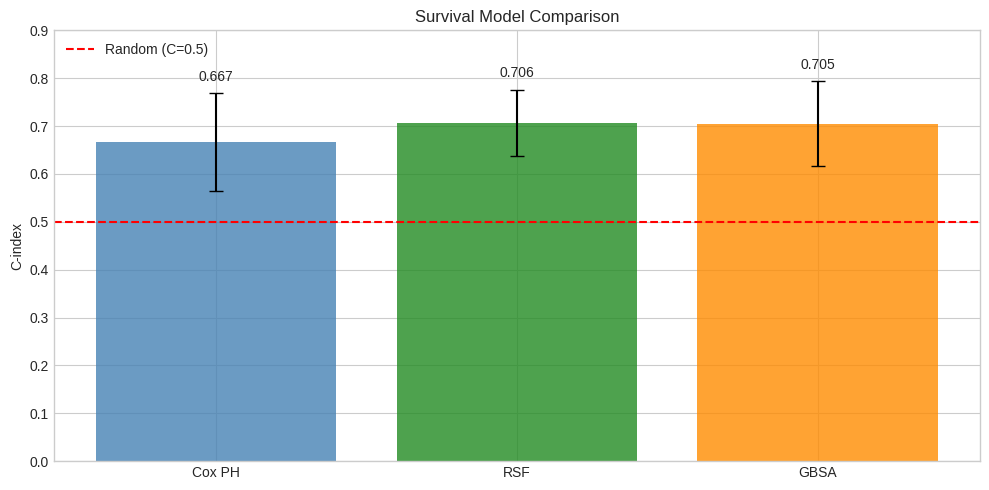

In [255]:
fig, ax = plt.subplots(figsize=(10, 5))

models = ['Cox PH', 'RSF', 'GBSA']
c_indices = [
    cox_results['c_index_mean'],
    rsf_results['c_index_mean'],
    gbsa_results['c_index_mean']
]
c_stds = [
    cox_results['c_index_std'],
    rsf_results['c_index_std'],
    gbsa_results['c_index_std']
]

colors = ['steelblue', 'forestgreen', 'darkorange']
bars = ax.bar(models, c_indices, yerr=c_stds, capsize=5, color=colors, alpha=0.8)

ax.axhline(y=0.5, color='red', linestyle='--', label='Random (C=0.5)')
ax.set_ylabel('C-index')
ax.set_title('Survival Model Comparison')
ax.set_ylim(0, 0.9)
ax.legend()

for bar, val, std in zip(bars, c_indices, c_stds):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + std + 0.02,
            f'{val:.3f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig(os.path.join(figures_dir, '03_model_comparison.png'), dpi=300, bbox_inches='tight')
plt.show()

## Kaplan-Meier Curves by Risk Group

Visualise how well the best model stratifies patients into risk groups.

### Stratify Patients by Predicted Risk

In [256]:
# Use the best-performing model to predict risk scores
risk_scores = rsf_full.predict(X_encoded)

# Split into tertiles (low, medium, high risk)
risk_tertiles = pd.qcut(risk_scores, q=3, labels=['Low Risk', 'Medium Risk', 'High Risk'])

print("Risk group distribution:")
print(risk_tertiles.value_counts().sort_index())

Risk group distribution:
Low Risk       68
Medium Risk    67
High Risk      68
Name: count, dtype: int64


### Plot Kaplan-Meier Curves

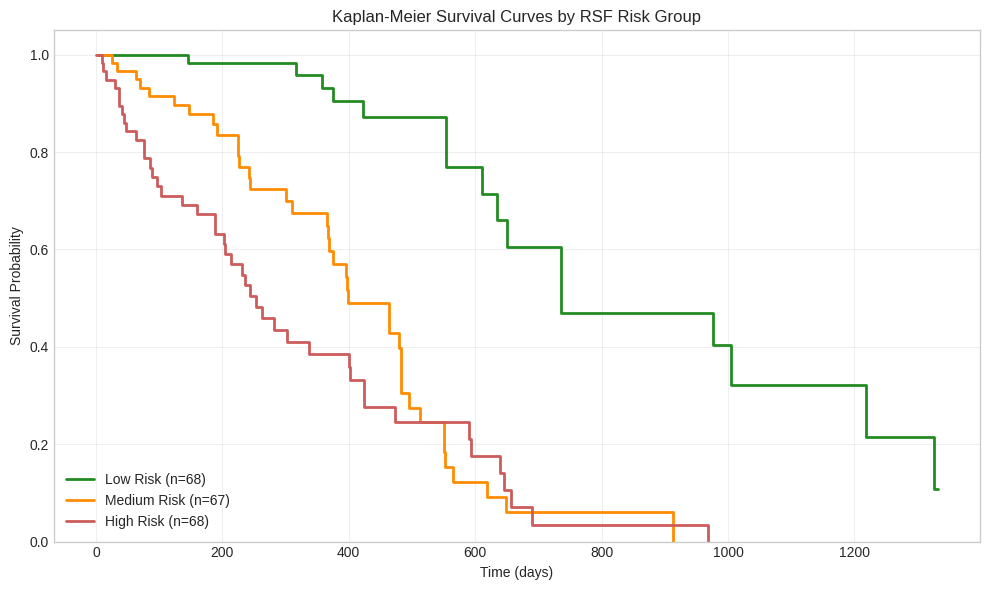

In [257]:
fig, ax = plt.subplots(figsize=(10, 6))

colors = {'Low Risk': 'forestgreen', 'Medium Risk': 'darkorange', 'High Risk': 'indianred'}

for group in ['Low Risk', 'Medium Risk', 'High Risk']:
    mask = risk_tertiles == group
    time_group = survival_time[mask]
    event_group = event[mask]

    km_time, km_surv = kaplan_meier_estimator(event_group, time_group)

    ax.step(km_time, km_surv, where='post', label=f'{group} (n={mask.sum()})',
            color=colors[group], linewidth=2)

ax.set_xlabel('Time (days)')
ax.set_ylabel('Survival Probability')
ax.set_title('Kaplan-Meier Survival Curves by RSF Risk Group')
ax.legend(loc='lower left')
ax.set_ylim(0, 1.05)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(figures_dir, '03_kaplan_meier_curves.png'), dpi=300, bbox_inches='tight')
plt.show()

## Save Results

### Save Model Comparison

In [261]:
results_dir = os.path.join(GLIOMA_DIR, 'results')
os.makedirs(results_dir, exist_ok=True)


model_results_list = [
    {'name': 'cox_ph', 'results': cox_results},
    {'name': 'random_survival_forest', 'results': rsf_results},
    {'name': 'gradient_boosted_survival', 'results': gbsa_results}
]

survival_results = {}

for model_info in model_results_list:
    model_name = model_info['name']
    results = model_info['results']
    survival_results[model_name] = {
        'c_index_mean': float(results['c_index_mean']),
        'c_index_std': float(results['c_index_std']),
        'c_index_scores': [float(x) for x in results['c_index_scores']]
    }


with open(os.path.join(results_dir, '03_survival_results.json'), 'w') as f:
    json.dump(survival_results, f, indent=2)

print(f"Saved: 03_survival_results.json")

Saved: 03_survival_results.json


### Save Feature Importances

In [260]:
cox_coefs.to_csv(os.path.join(results_dir, '03_cox_coefficients.csv'), index=False)
print("Saved: 03_cox_coefficients.csv")

rsf_importance.to_csv(os.path.join(results_dir, '03_rsf_feature_importance.csv'), index=False)
print("Saved: 03_rsf_feature_importance.csv")

gbsa_importance.to_csv(os.path.join(results_dir, '03_gbsa_feature_importance.csv'), index=False)
print("Saved: 03_gbsa_feature_importance.csv")

Saved: 03_cox_coefficients.csv
Saved: 03_rsf_feature_importance.csv
Saved: 03_gbsa_feature_importance.csv


## Summary

This notebook implemented three survival analysis models:

1. **Cox Proportional Hazards**: Linear model assuming proportional hazards
2. **Random Survival Forest**: Non-linear ensemble method
3. **Gradient Boosted Survival**: Boosting approach for survival data

**Key findings:**
- C-index values are comparable to AUC from binary classification
- Survival analysis properly handles censored observations
- Kaplan-Meier curves show the model's ability to stratify patients by risk
- Top features align with binary classification results (IDH mutation, primary diagnosis, etc.)

**Methodological note:**
- For patients who died: used actual days-to-death from original data
- For censored patients: used last MRI timepoint as proxy for follow-up time

**For the report:**
- Compare binary classification AUC with survival analysis C-index
- Discuss trade-offs: binary classification is simpler; survival analysis is methodologically correct
- Use Kaplan-Meier curves to demonstrate clinical utility of risk stratification